In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sktime.forecasting.ets import AutoETS
#from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    ExpandingWindowSplitter,)
from sktime.transformations.series.boxcox import LogTransformer
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.model_evaluation import evaluate
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sktime.forecasting.arima import AutoARIMA

In [2]:
df = pd.read_excel(r'C:\Users\kosta\Documents\PhD related\Python\Feature forecasting\All metals.xlsx',parse_dates = ['DATE'],index_col='DATE')

In [3]:
df.index = pd.PeriodIndex(df.index, freq="M")

In [4]:
copper = df['COPPER'].to_frame()

In [5]:
# trans1 = LogTransformer()
# copper = trans1.fit_transform(copper)

In [6]:
copper = copper.diff().dropna()

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

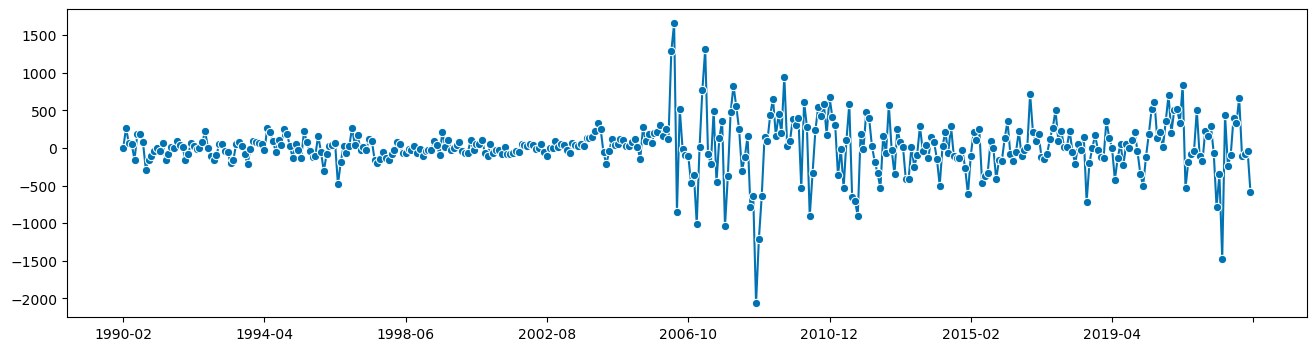

In [7]:
plot_series(copper)

In [8]:
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2022-04-01", periods=6, freq="M")), is_relative=False)
fh

ForecastingHorizon(['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09'], dtype='period[M]', is_relative=False)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

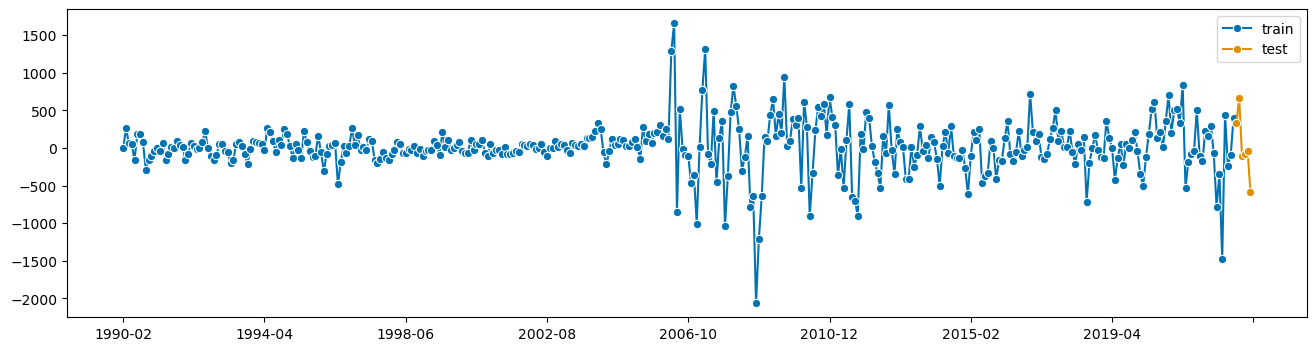

In [9]:
y_train, y_test = temporal_train_test_split(copper, test_size = 6)
plot_series(y_train,y_test,labels=['train','test'])

In [10]:
int(len(y_train) * 0.8)

315

In [11]:
len(y_train)

394

In [12]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy="recursive")
param_grid = {"estimator__n_neighbors":np.arange(1,15),
              "window_length": np.arange(1,10)}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = ExpandingWindowSplitter(initial_window=int(len(y_train) * 0.8), fh=np.arange(1,7))
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid,scoring= MeanSquaredError(square_root=True)
)

In [13]:
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor())

In [14]:
gscv.fit(y_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]),
                                                   initial_window=315),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor()),
                        param_grid={'estimator__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                    'window_length': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                        scoring=MeanSquaredError(square_root=True))

In [15]:
gscv.best_forecaster_

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                     window_length=8)

In [16]:
gscv.best_score_

304.07492530332564

In [17]:
fh = ForecastingHorizon(np.arange(1,7))

In [18]:
y_pred = gscv.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

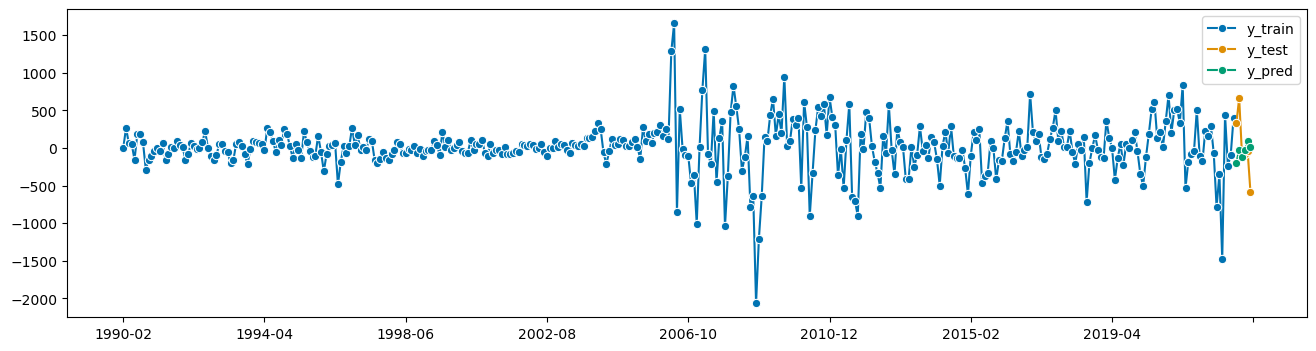

In [19]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [21]:
print(np.sqrt(mean_squared_error(y_test,y_pred)))

711.2838473328471


In [22]:
forecaster = gscv.best_forecaster_

In [23]:
evalu = evaluate(forecaster,cv=cv,y=y_train,return_data=True)

In [24]:
evalu

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.867438,0.023490,0.011690,309,2015-10,COPPER 1990-02 -6.48 1990-03 265.4...,COPPER 2015-11 -416.19 2015-12 -161.0...,COPPER 2015-11 81.97363 2015-12 ...
1,0.778060,0.019707,0.011326,310,2015-11,COPPER 1990-02 -6.48 1990-03 265.4...,COPPER 2015-12 -161.07 2016-01 -167.0...,COPPER 2015-12 -75.854 2016-01 13.38...
2,0.954248,0.020958,0.010684,311,2015-12,COPPER 1990-02 -6.48 1990-03 265.4...,COPPER 2016-01 -167.04 2016-02 126.8...,COPPER 2016-01 13.380 2016-02 11.67...
3,0.875816,0.021411,0.011876,312,2016-01,COPPER 1990-02 -6.48 1990-03 265.4...,COPPER 2016-02 126.83 2016-03 355.1...,COPPER 2016-02 -38.232000 2016-0...
4,0.805437,0.021873,0.011130,313,2016-02,COPPER 1990-02 -6.48 1990-03 265.4...,COPPER 2016-03 355.18 2016-04 -81.0...,COPPER 2016-03 62.494 2016-04 -108...
...,...,...,...,...,...,...,...,...
68,1.965898,0.026118,0.012923,377,2021-06,COPPER 1990-02 -6.48 1990-03 265.4...,COPPER 2021-07 -180.68 2021-08 -80.6...,COPPER 2021-07 197.4152 2021-08 1...
69,0.542355,0.028107,0.011335,378,2021-07,COPPER 1990-02 -6.48 1990-03 265.4...,COPPER 2021-08 -80.68 2021-09 -45.4...,COPPER 2021-08 28.502400 2021-0...
70,0.559127,0.024569,0.010889,379,2021-08,COPPER 1990-02 -6.48 1990-03 265.4...,COPPER 2021-09 -45.43 2021-10 504.5...,COPPER 2021-09 -97.959200 2021-1...
71,0.598924,0.024227,0.013324,380,2021-09,COPPER 1990-02 -6.48 1990-03 265.4...,COPPER 2021-10 504.51 2021-11 -100.3...,COPPER 2021-10 216.765800 2021-1...


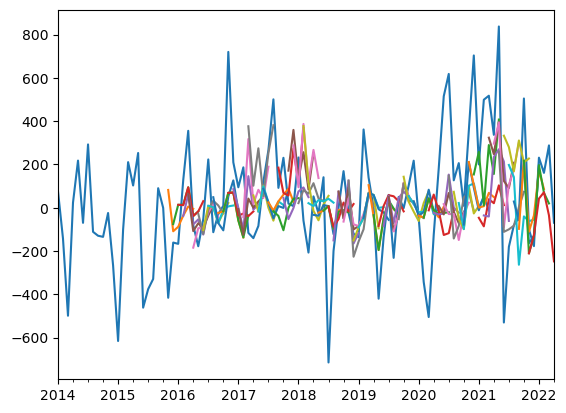

In [25]:
ax = y_train.iloc[-100:].plot()
for i in range(len(evalu)):
    evalu['y_pred'].iloc[i].plot(ax=ax)
    ax.get_legend().remove()


In [26]:
regressor = RandomForestRegressor(random_state=0)
forecaster = make_reduction(regressor, strategy="recursive")
param_grid = {"estimator__n_estimators":[50,100,150,200],
              "window_length": np.arange(1,10)}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = ExpandingWindowSplitter(initial_window=int(len(y_train) * 0.8), fh=np.arange(1,7))
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid,scoring= MeanSquaredError(square_root=True),
verbose=3)

In [27]:
gscv.get_params().keys()

dict_keys(['backend', 'cv__fh', 'cv__initial_window', 'cv__start_with_window', 'cv__step_length', 'cv', 'forecaster__estimator__bootstrap', 'forecaster__estimator__ccp_alpha', 'forecaster__estimator__criterion', 'forecaster__estimator__max_depth', 'forecaster__estimator__max_features', 'forecaster__estimator__max_leaf_nodes', 'forecaster__estimator__max_samples', 'forecaster__estimator__min_impurity_decrease', 'forecaster__estimator__min_samples_leaf', 'forecaster__estimator__min_samples_split', 'forecaster__estimator__min_weight_fraction_leaf', 'forecaster__estimator__n_estimators', 'forecaster__estimator__n_jobs', 'forecaster__estimator__oob_score', 'forecaster__estimator__random_state', 'forecaster__estimator__verbose', 'forecaster__estimator__warm_start', 'forecaster__estimator', 'forecaster__transformers', 'forecaster__window_length', 'forecaster', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_n_best_forecasters', 'scoring__multilevel', 'scoring__multioutput', 'scoring_

In [28]:
gscv.fit(y_train)

Fitting 73 folds for each of 36 candidates, totalling 2628 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]), initial_window=None),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=0)),
                        param_grid={'estimator__n_estimators': [50, 100, 150,
                                                                200],
                                    'window_length': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                        scoring=MeanSquaredError(square_root=True), verbose=3)

In [29]:
forecaster = gscv.best_forecaster_
forecaster

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=0),
                                     window_length=4)

In [30]:
evalu = evaluate(forecaster,cv=cv,y=y_train,return_data=True,scoring=MeanSquaredError(square_root=True))
print(f"Mean MSE {evalu['test_MeanSquaredError'].mean()}, +- {evalu['test_MeanSquaredError'].std()}")

Mean MSE 274.923932908533, +- 95.62285414978366


In [31]:
evalu['y_pred'].iloc[-3]

,COPPER
2021-09,107.253330
2021-10,177.583260
2021-11,81.245007
2021-12,-101.709960
2022-01,-70.200154
2022-02,-23.855960


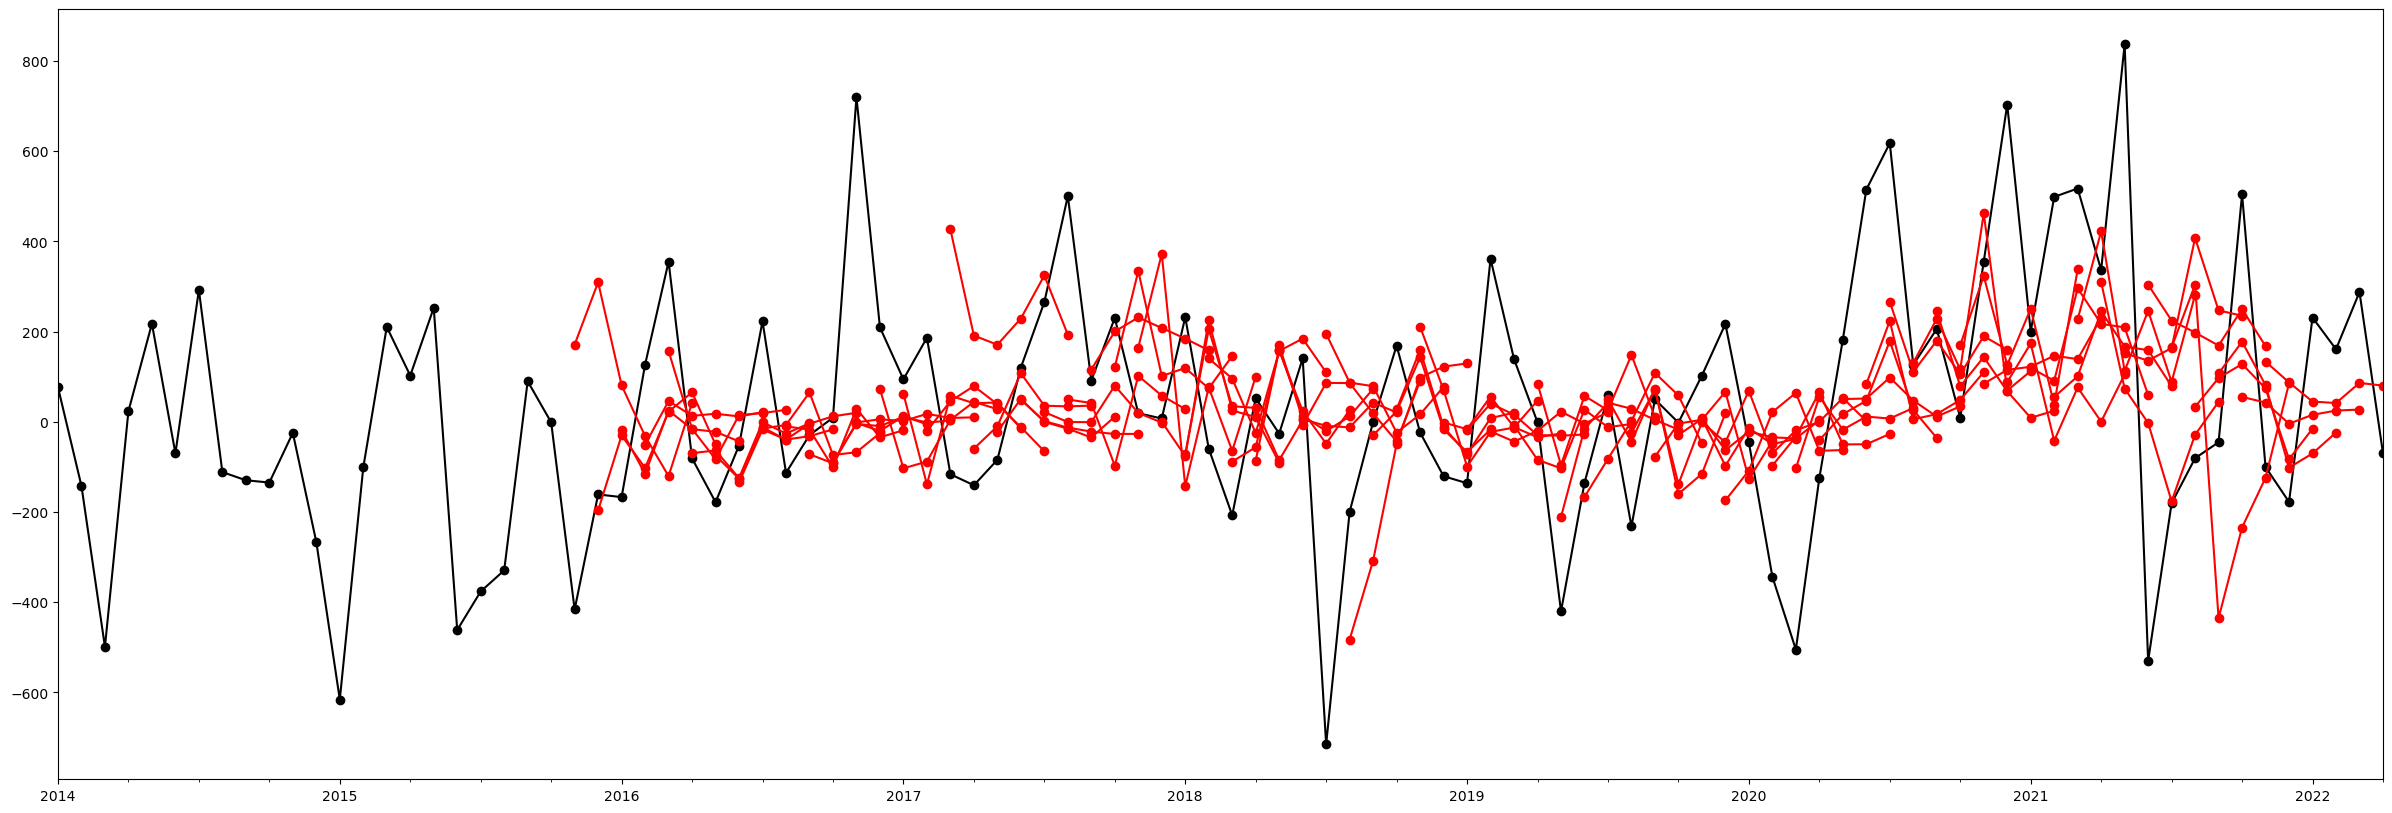

In [32]:

ax = y_train.iloc[-100:].plot(marker='o',figsize=(30,10),c='black')
for i in range(len(evalu)):
    evalu['y_pred'].iloc[i].plot(ax=ax,marker='o',c='red',figsize=(30,10))
    ax.get_legend().remove()

In [33]:
y_pred = gscv.predict(fh)

C:\Users\kosta\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py:201: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

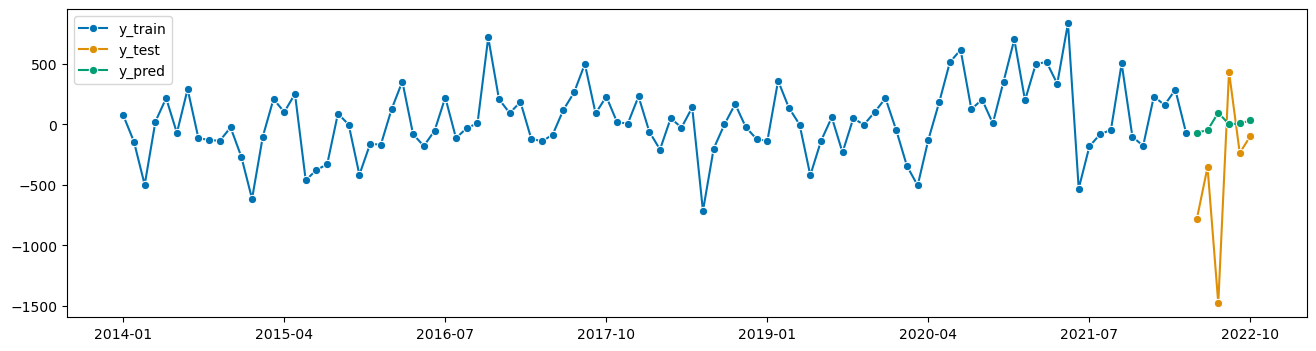

In [34]:
plot_series(y_train.iloc[-100:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [35]:
print(np.sqrt(mean_squared_error(y_test,y_pred)))

748.2799613286699


In [36]:
evalu = evaluate(NaiveForecaster('mean'),cv=cv,y=y_train,return_data=True,scoring=MeanSquaredError(square_root=True))
print(f"Mean MSE {evalu['test_MeanSquaredError'].mean()}, +- {evalu['test_MeanSquaredError'].std()}")

Mean MSE 271.9785236292923, +- 107.14734615117008


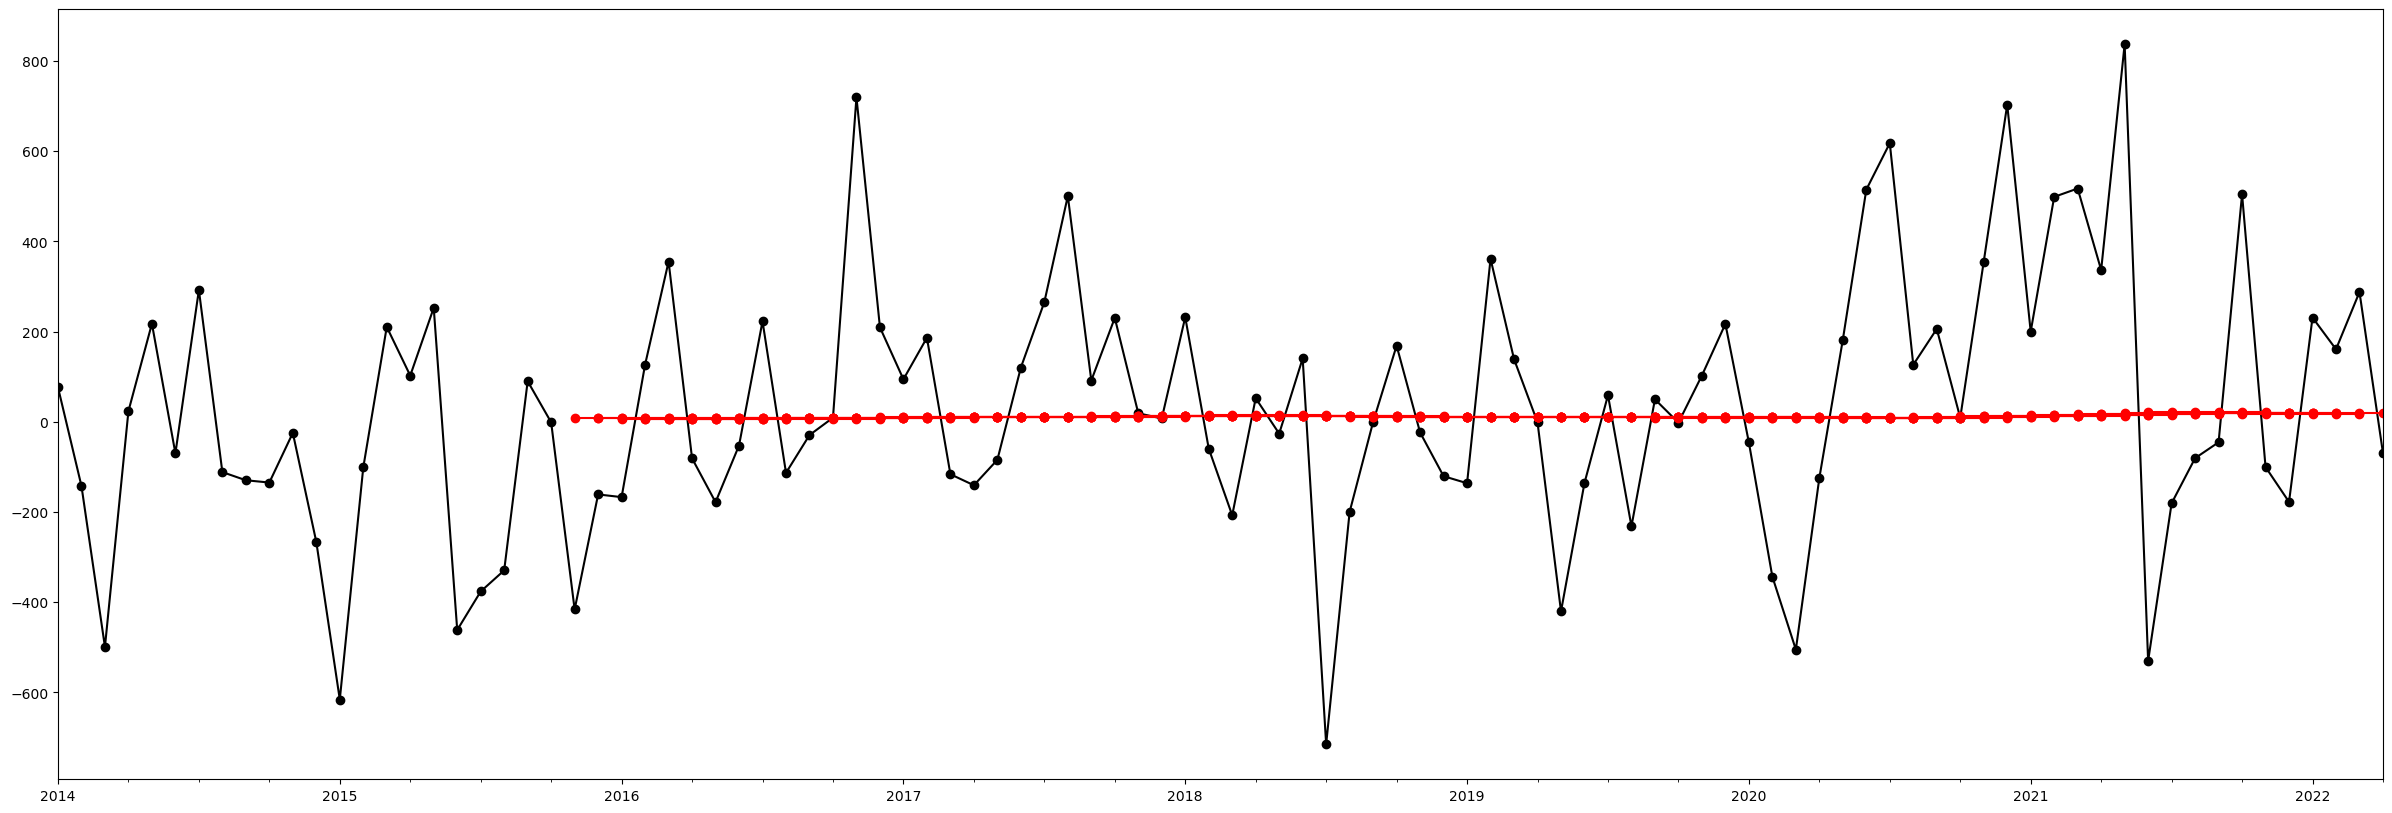

In [37]:

ax = y_train.iloc[-100:].plot(marker='o',figsize=(30,10),c='black')
for i in range(len(evalu)):
    evalu['y_pred'].iloc[i].plot(ax=ax,marker='o',c='red',figsize=(30,10))
    ax.get_legend().remove()

In [38]:
f = NaiveForecaster('mean')
f.fit(y_train)
preds = f.predict(fh)

In [39]:
print(np.sqrt(mean_squared_error(y_test,preds)))

740.2645903640685


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

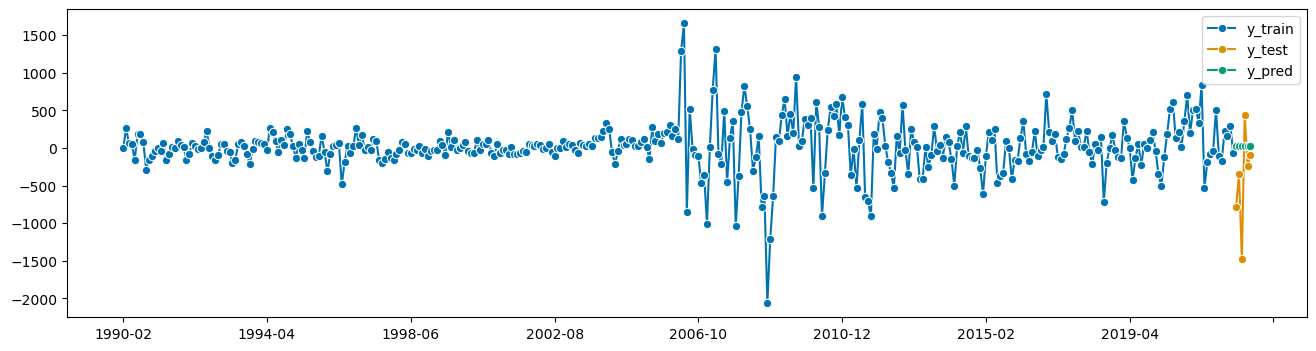

In [40]:
forecasternaive = NaiveForecaster('mean').fit(y_train)
y_pred = forecasternaive.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [20]:
regressor = MLPRegressor(random_state=0,max_iter=2000,shuffle=False)
forecaster = make_reduction(regressor, strategy="recursive")
param_grid = {"estimator__hidden_layer_sizes":[(20,)],
              "window_length": np.arange(1,10)}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = ExpandingWindowSplitter(initial_window=int(len(y_train) * 0.8), fh=np.arange(1,7))
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid,scoring= MeanSquaredError(square_root=True),
verbose=3)

In [21]:
gscv.get_params()

{'backend': 'loky',
 'cv': ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]), initial_window=315),
 'error_score': nan,
 'forecaster': RecursiveTabularRegressionForecaster(estimator=MLPRegressor(max_iter=2000, random_state=0, shuffle=False)),
 'n_jobs': None,
 'param_grid': {'estimator__hidden_layer_sizes': [(20,)],
  'window_length': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_n_best_forecasters': 1,
 'scoring': MeanSquaredError(square_root=True),
 'strategy': 'refit',
 'update_behaviour': 'full_refit',
 'verbose': 3,
 'cv__fh': array([1, 2, 3, 4, 5, 6]),
 'cv__initial_window': 315,
 'cv__step_length': 1,
 'forecaster__estimator': MLPRegressor(max_iter=2000, random_state=0, shuffle=False),
 'forecaster__pooling': 'local',
 'forecaster__transformers': None,
 'forecaster__window_length': 10,
 'forecaster__estimator__activation': 'relu',
 'forecaster__estimator__alpha': 0.0001,
 'forecaster__estimator__batch_size': 'auto',
 'forecaster__e

In [22]:
gscv.fit(y_train)

Fitting 74 folds for each of 9 candidates, totalling 666 fits


C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_m

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]),
                                                   initial_window=315),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=MLPRegressor(hidden_layer_sizes=(20,), max_iter=2000, random_state=0,
             shuffle=False)),
                        param_grid={'estimator__hidden_layer_sizes': [(20,)],
                                    'window_length': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                        scoring=MeanSquaredError(square_root=True), verbose=3)

In [44]:
forecaster = gscv.best_forecaster_
forecaster

RecursiveTabularRegressionForecaster(estimator=MLPRegressor(hidden_layer_sizes=(20,),
                                                            max_iter=2000,
                                                            random_state=0,
                                                            shuffle=False),
                                     window_length=1)

In [24]:
evalu = evaluate(forecaster,cv=cv,y=y_train,return_data=True,scoring=MeanSquaredError(square_root=True))
evalu['test_MeanSquaredError'].mean()

C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kosta\anaconda3\lib\site-packages\sklearn\neural_network\_m

443.69103234040665

In [25]:
print(f"Mean MSE {evalu['test_MeanSquaredError'].mean()}, +- {evalu['test_MeanSquaredError'].std()}")

Mean MSE 443.69103234040665, +- 232.20926199627894


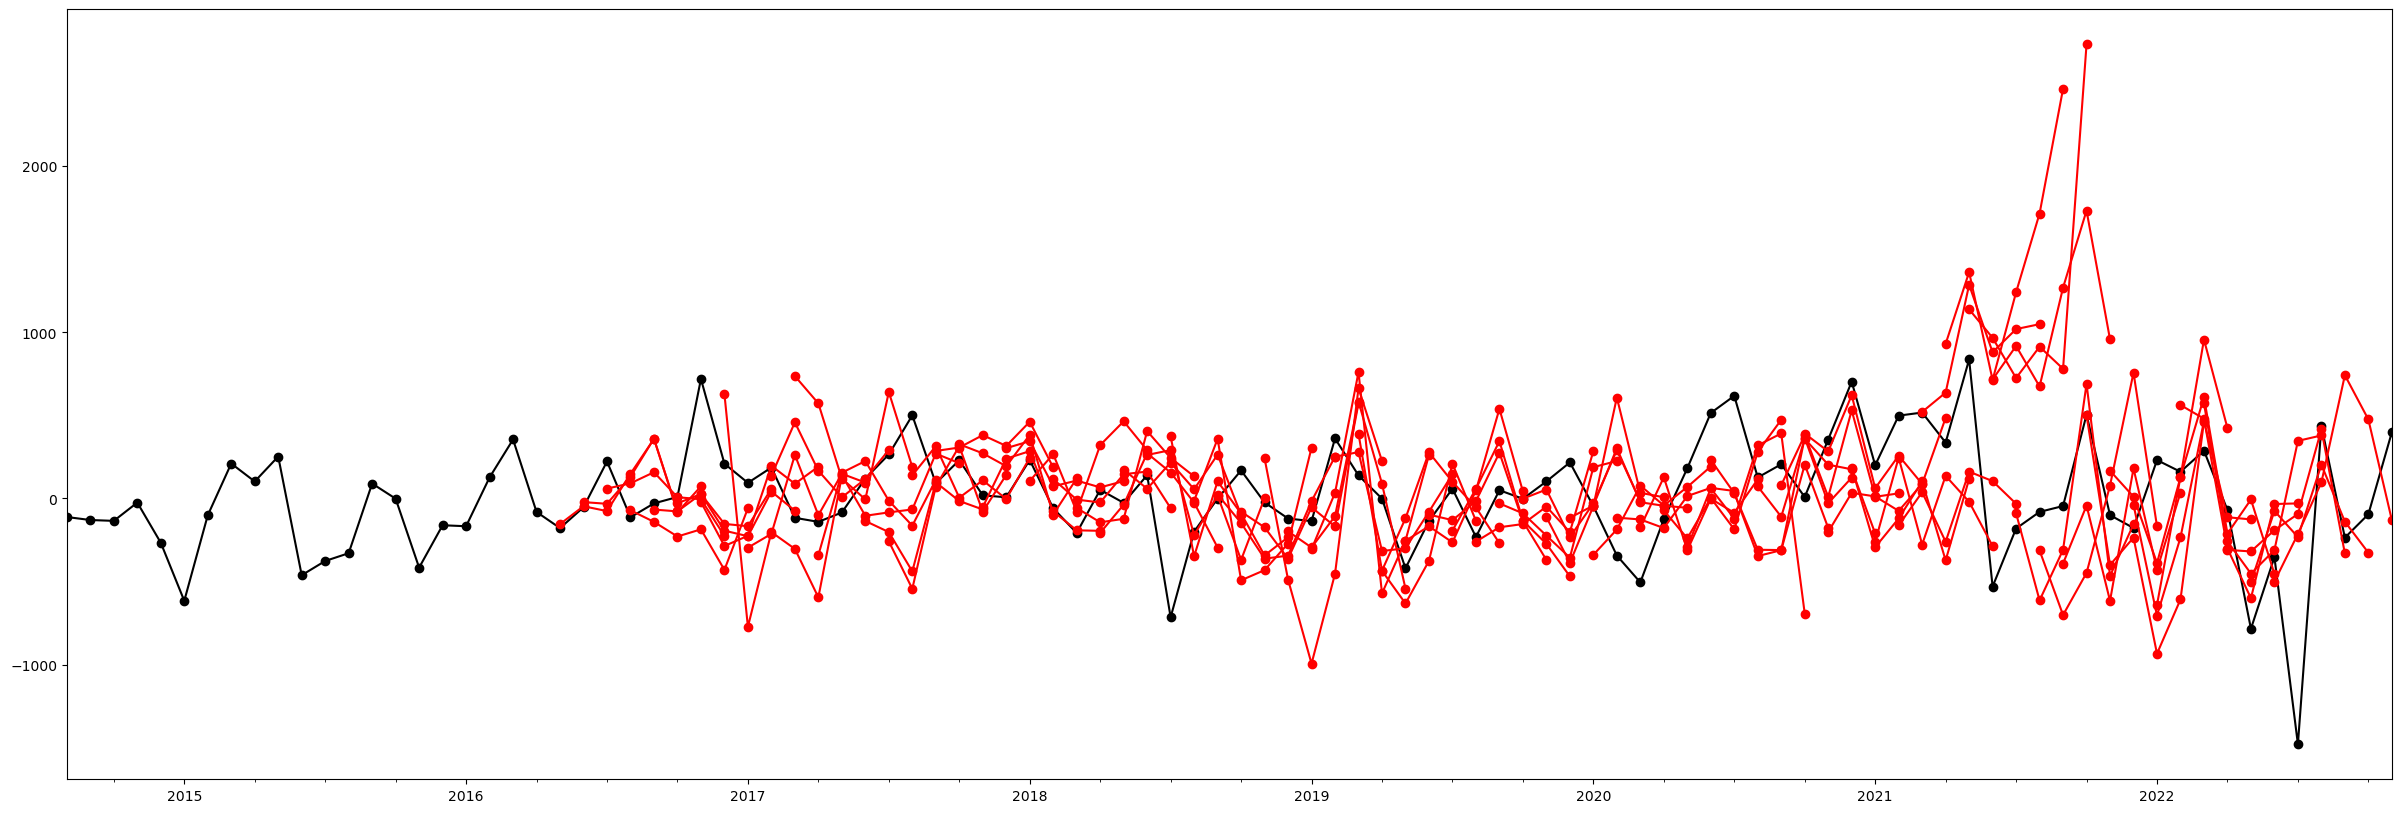

In [26]:
ax = y_train.iloc[-100:].plot(marker='o',figsize=(30,10),c='black')
for i in range(len(evalu)):
    evalu['y_pred'].iloc[i].plot(ax=ax,marker='o',c='red',figsize=(30,10))
    ax.get_legend().remove()

In [48]:
y_preds = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

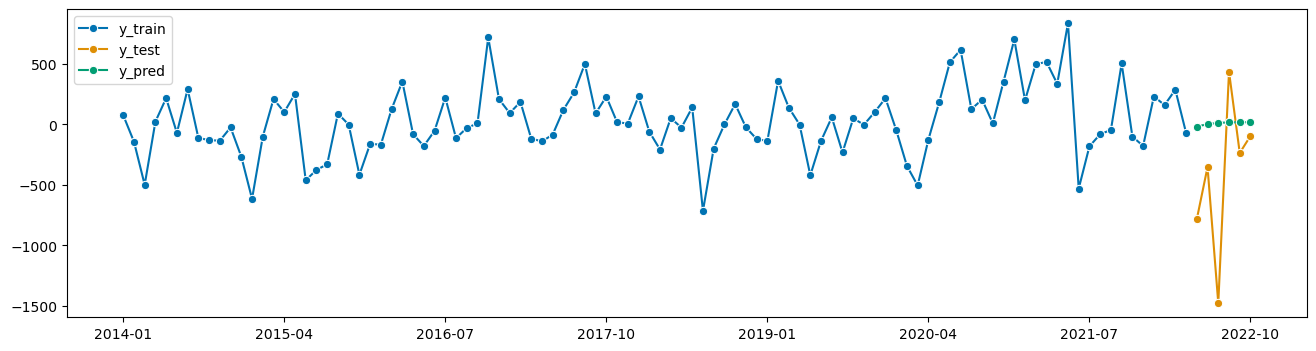

In [49]:
plot_series(y_train.iloc[-100:], y_test, y_preds, labels=["y_train", "y_test", "y_pred"])

In [50]:
print(np.sqrt(mean_squared_error(y_test,y_preds)))

729.8206603261684


In [51]:
forecaster = AutoETS()
cv = ExpandingWindowSplitter(initial_window=int(len(y_train) * 0.8), fh=np.arange(1,7))
evalu = evaluate(forecaster,cv=cv,y=y_train,return_data=True,scoring=MeanSquaredError(square_root=True))

In [52]:
print(f"Mean MSE {evalu['test_MeanSquaredError'].mean()}, +- {evalu['test_MeanSquaredError'].std()}")

Mean MSE 279.98543130388185, +- 110.5339090878228


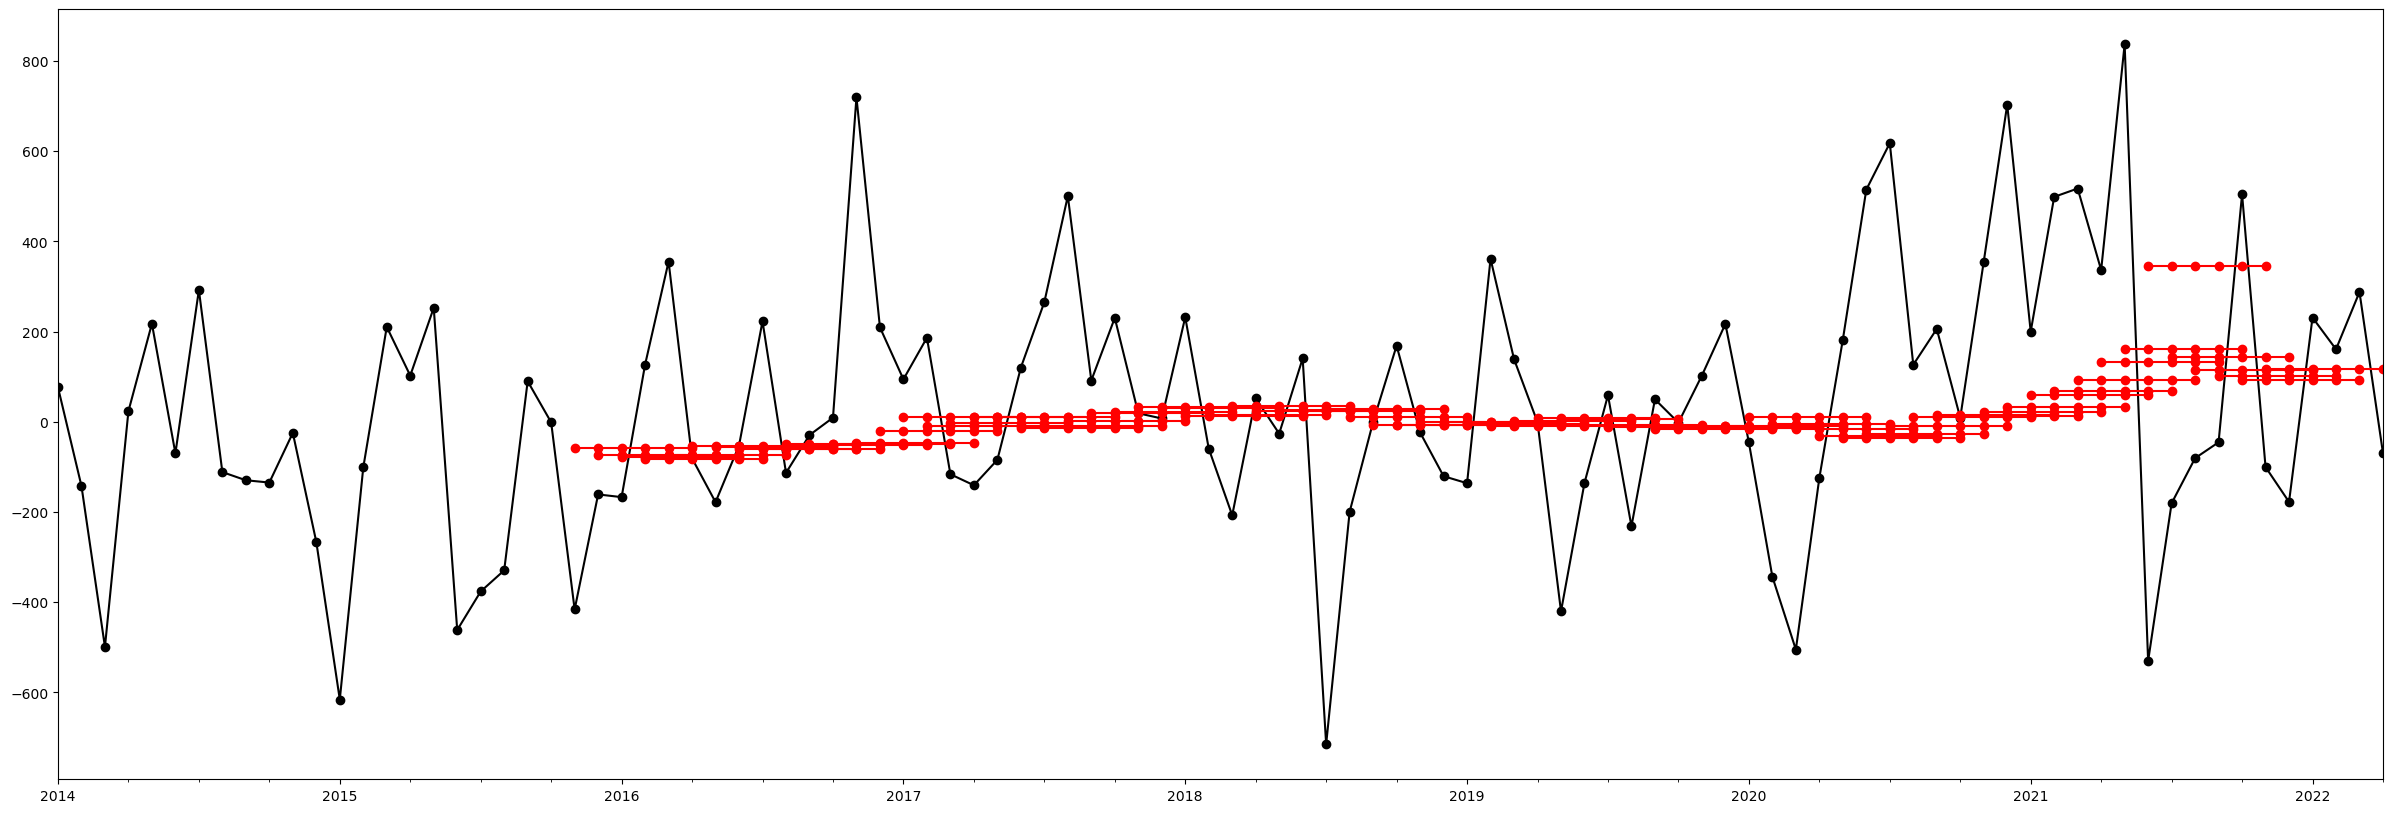

In [53]:
ax = y_train.iloc[-100:].plot(marker='o',figsize=(30,10),c='black')
for i in range(len(evalu)):
    evalu['y_pred'].iloc[i].plot(ax=ax,marker='o',c='red',figsize=(30,10))
    ax.get_legend().remove()

In [54]:
forecaster = AutoETS()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)


In [55]:
print(np.sqrt(mean_squared_error(y_test,y_pred)))

789.7784597959713


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

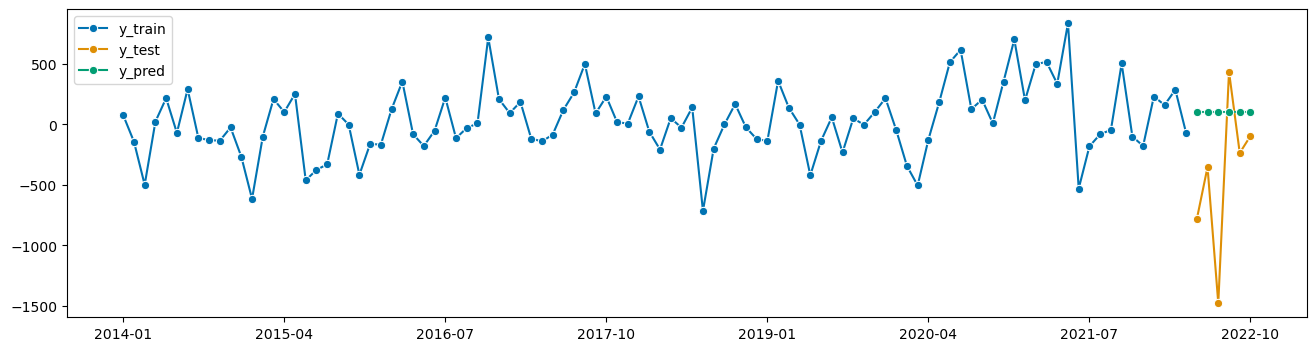

In [56]:
plot_series(y_train.iloc[-100:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [78]:
regressor = XGBRegressor(random_state=0)
forecaster = make_reduction(regressor, strategy="recursive")
param_grid = {'estimator__booster' :['gbtree', 'gblinear','dart'],
    "estimator__n_estimators":[50,100,150,200],
              "window_length": np.arange(1,10)}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = ExpandingWindowSplitter(initial_window=int(len(y_train) * 0.8), fh=np.arange(1,7))
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid,scoring= MeanSquaredError(square_root=True),
verbose=3)

In [80]:
gscv.fit(y_train)

Fitting 73 folds for each of 108 candidates, totalling 7884 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]), initial_window=None),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=XGBRegressor(base_score=None,
                                                                                               booster=None,
                                                                                               colsample_bylevel=None,
                                                                                               colsample_bynode=None,
                                                                                               colsample_bytree=None,
                                                                                               enable_categorical=False,
                                                                                               gamma=None,
                                                                                               gpu_id=None,
                                                                                               importance_type=None,
                                                                                               interaction_constr...
                                                                                               predictor=None,
                                                                                               random_state=0,
                                                                                               reg_alpha=None,
                                                                                               reg_lambda=None,
                                                                                               scale_pos_weight=None,
                                                                                               subsample=None,
                                                                                               tree_method=None,
                                                                                               validate_parameters=None,
                                                                                               verbosity=None)),
                        param_grid={'estimator__booster': ['gbtree', 'gblinear',
                                                           'dart'],
                                    'estimator__n_estimators': [50, 100, 150,
                                                                200],
                                    'window_length': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                        scoring=MeanSquaredError(square_root=True), verbose=3)

In [59]:
forecaster = gscv.best_forecaster_
forecaster

RecursiveTabularRegressionForecaster(estimator=XGBRFRegressor(base_score=None,
                                                              booster=None,
                                                              colsample_bylevel=None,
                                                              colsample_bytree=None,
                                                              enable_categorical=False,
                                                              gamma=None,
                                                              gpu_id=None,
                                                              importance_type=None,
                                                              interaction_constraints=None,
                                                              max_delta_step=None,
                                                              max_depth=None,
                                                              min_child_weight=None,
                                                              missing=nan,
                                                              monotone_constraints=None,
                                                              n_estimators=150,
                                                              n_jobs=None,
                                                              num_parallel_tree=None,
                                                              objective='reg:squarederror',
                                                              predictor=None,
                                                              random_state=0,
                                                              reg_alpha=None,
                                                              scale_pos_weight=None,
                                                              tree_method=None,
                                                              validate_parameters=None,
                                                              verbosity=None),
                                     window_length=4)

In [81]:
evalu = evaluate(forecaster,cv=cv,y=y_train,return_data=True,scoring=MeanSquaredError(square_root=True))

In [82]:
print(f"Mean MSE {evalu['test_MeanSquaredError'].mean()}, +- {evalu['test_MeanSquaredError'].std()}")

Mean MSE 301.8634922109775, +- 131.71793613127662


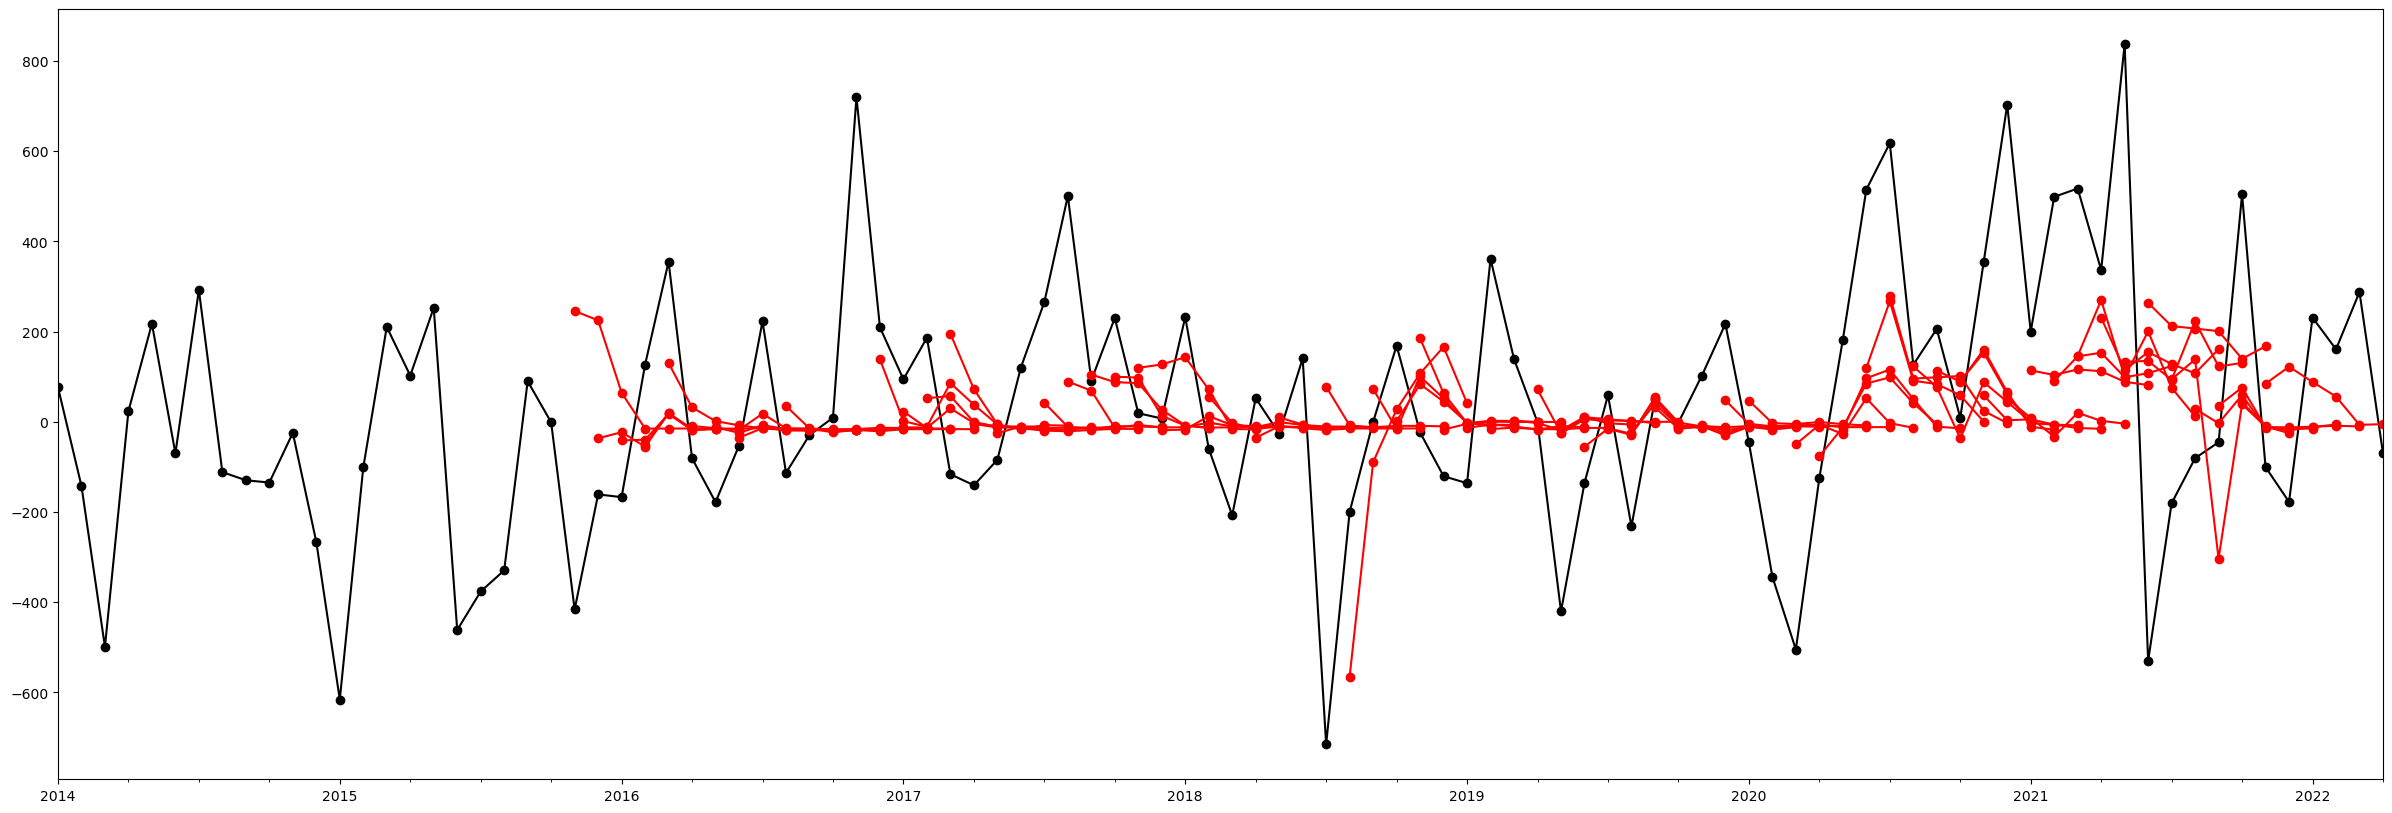

In [62]:
ax = y_train.iloc[-100:].plot(marker='o',figsize=(30,10),c='black')
for i in range(len(evalu)):
    evalu['y_pred'].iloc[i].plot(ax=ax,marker='o',c='red',figsize=(30,10))
    ax.get_legend().remove()

In [63]:
y_preds = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

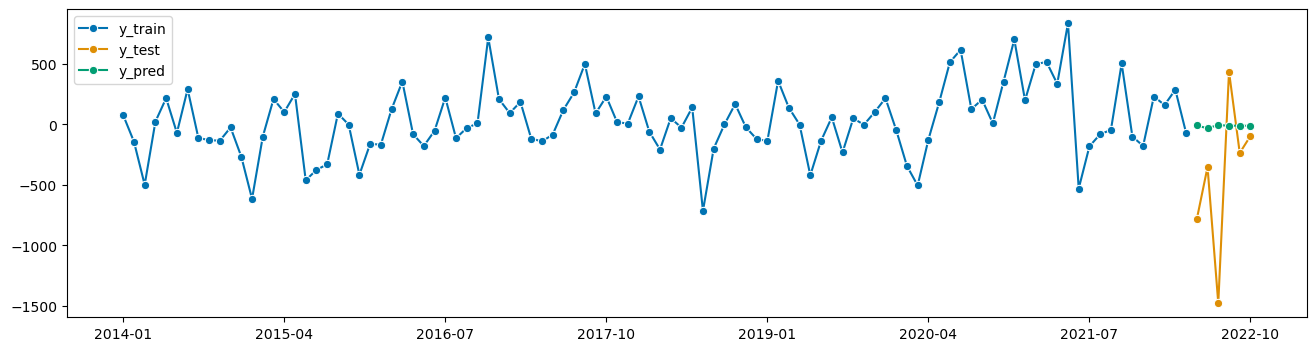

In [64]:
plot_series(y_train.iloc[-100:], y_test, y_preds, labels=["y_train", "y_test", "y_pred"])

In [65]:
print(np.sqrt(mean_squared_error(y_test,y_preds)))

723.7256531610676


In [66]:
forecaster = AutoARIMA()

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = ExpandingWindowSplitter(initial_window=int(len(y_train) * 0.8), fh=np.arange(1,7))
evaluator_arima = evaluate(forecaster,cv = cv,y=y_train,scoring=MeanSquaredError(square_root=True),return_data=True)

C:\Users\kosta\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kosta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kosta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kosta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kosta\anaconda3\lib\site-packa

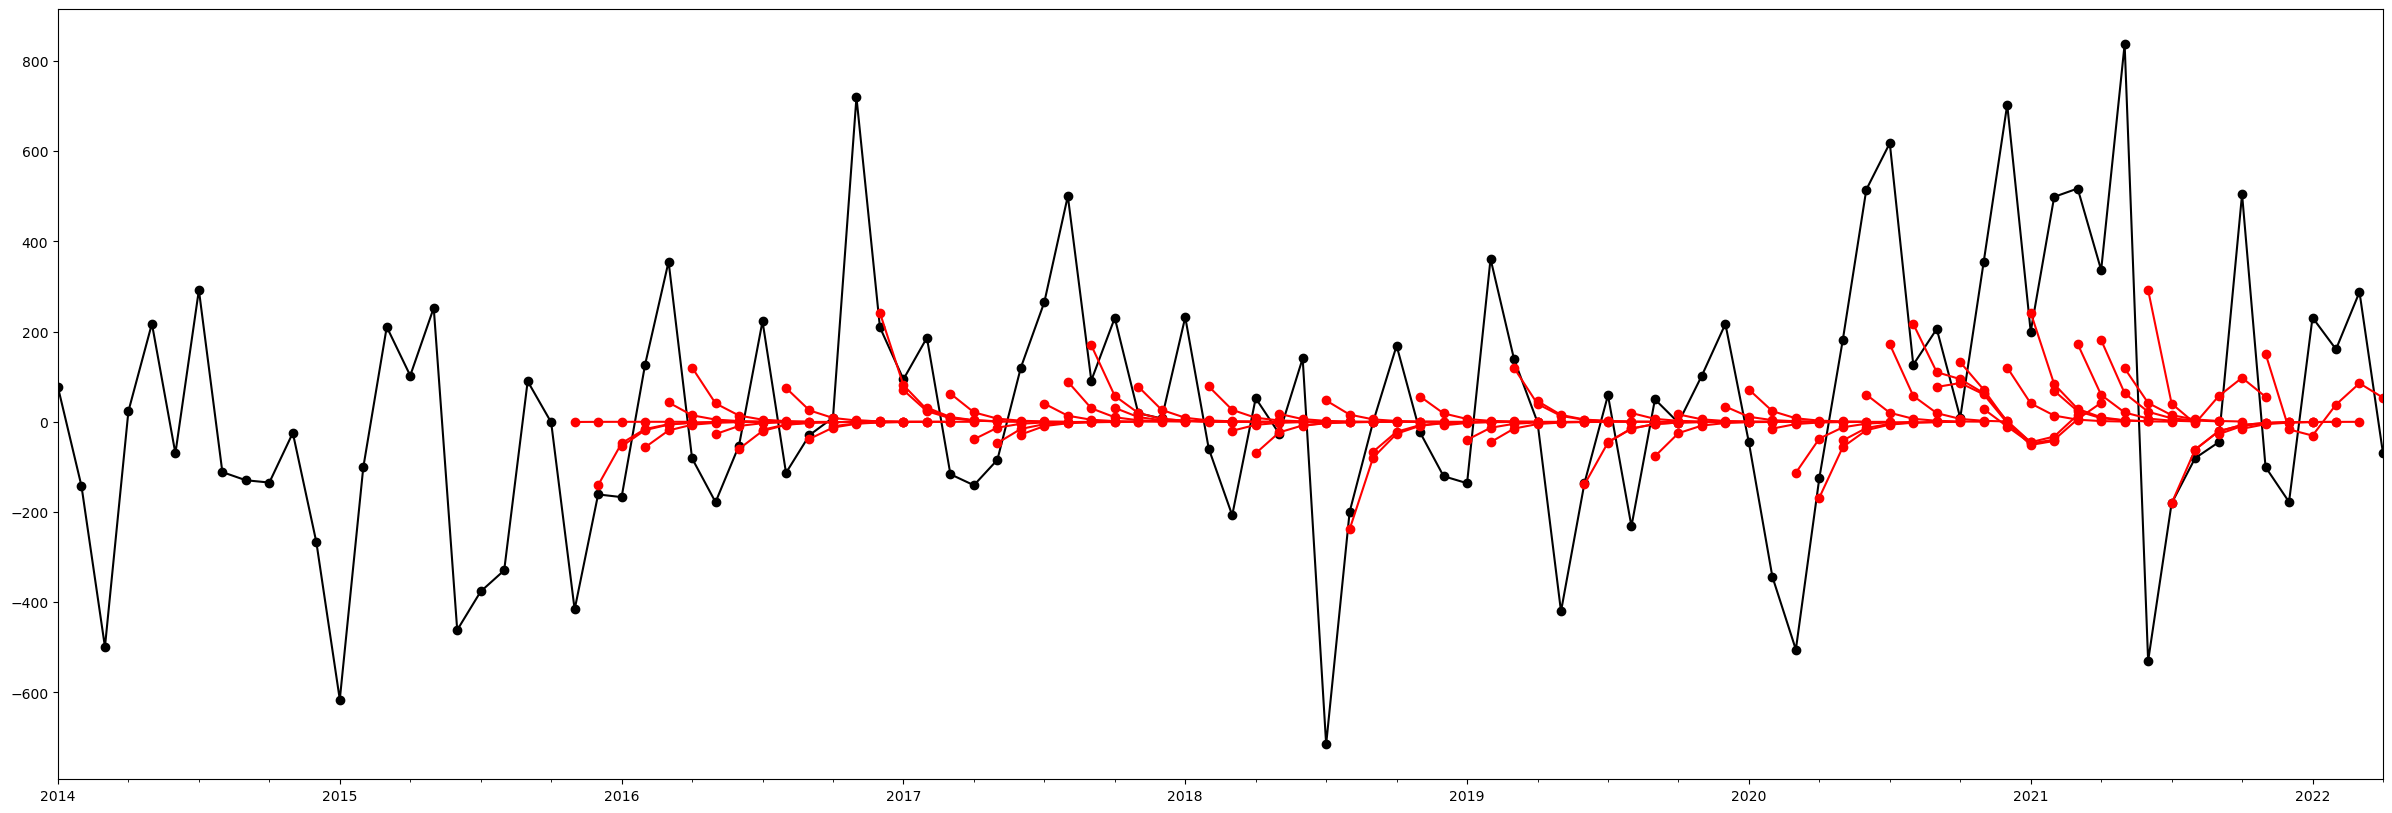

In [67]:
ax = y_train.iloc[-100:].plot(marker='o',figsize=(30,10),c='black')
for i in range(len(evaluator_arima)):
    evaluator_arima['y_pred'].iloc[i].plot(ax=ax,marker='o',c='red',figsize=(30,10))
    ax.get_legend().remove()

In [68]:
print(f"Mean MSE {evaluator_arima['test_MeanSquaredError'].mean()}, +- {evaluator_arima['test_MeanSquaredError'].std()}")

Mean MSE 270.9609563771772, +- 106.32452265496147


<AxesSubplot:>

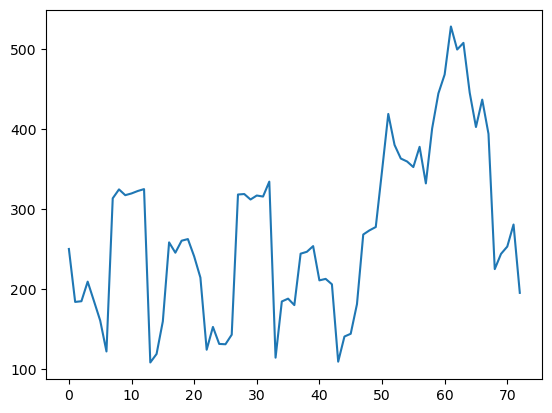

In [70]:
evaluator_arima['test_MeanSquaredError'].plot()